### Clustering Methods - Introduction to Statistical Learning chapter 12.4
https://www.statlearning.com/

Suppose that we have a set of n observations, each with p features. The n observations could correspond to tissue samples for patients with breast cancer, and the p features could correspond to measurements collected for each tissue sample; these could be clinical measurements, such as tumor stage or grade, or they could be gene expression measurements.

We may have a reason to believe that there is some heterogeneity among the n tissue samples; for instance, perhaps there are a few diferent unknown subtypes of breast cancer. Clustering could be used to fnd these subgroups. This is an unsupervised problem because we are trying to discover structure—in this case, distinct clusters—on the basis of a data set.

Another application of clustering arises in marketing. We may have access to a large number of measurements (e.g. median household income, occupation, distance from nearest urban area, and so forth) for a large number of people. Our goal is to perform market segmentation by identifying subgroups of people who might be more receptive to a particular form of advertising, or more likely to purchase a particular product. The task of performing market segmentation amounts to clustering the people in the data set.

In general, we can cluster observations on the basis of the features in order to identify subgroups among the observations, or we can cluster features on the basis of the observations in order to discover subgroups among the features (this can be performed by simply transposing the data matrix).

**K-Means Clustering**

K-means clustering partition a data set into K distinct, non-overlapping clusters.

Objective function:

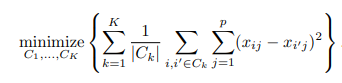

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_blobs

In [2]:
plt.rcParams['figure.figsize'] = (4, 4)

In [3]:
# Make data
X, y = make_blobs(centers=3, n_samples=500, n_features=2, cluster_std=1, 
                  shuffle=True, random_state=40)

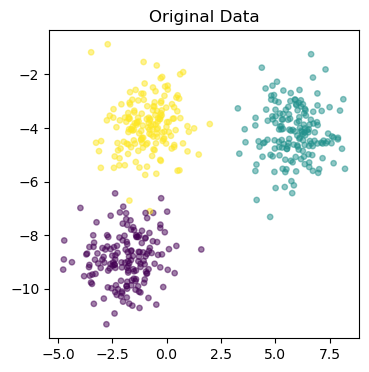

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=15, alpha=0.5)
plt.title('Original Data');

In [5]:
# Reference: https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/kmeans.py
# I added 'farthest' method to initialize centroids
class KMeans:
    def __init__(self, n_clusters=5, max_iter=300, init_centroid='random', plot_step=False):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.init_centroid = init_centroid
        self.plot_step = plot_step
        self.clusters = [[] for _ in range(self.n_clusters)]   # hold indices of samples within each cluster
        self.centroids = []    # mean feature vector for each cluster (K x n_features)
        
    
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        # Initialize centroids
        if self.init_centroid == 'random':    # initialize centroids randomly
            idxs = np.random.choice(self.n_samples, self.n_clusters, replace=False)
            self.centroids = self.X[idxs]
               
        else:    # initialize centroids with samples that are farthest from each other                  
            # pick the first centroid randomly
            centroid = self.X[np.random.choice(self.n_samples)].tolist()
            self.centroids.append(centroid)
            
            for i in range(1, self.n_clusters):
                # calculate squared distances from each point to the current centroids
                distances = [min([np.linalg.norm(x - c) for c in self.centroids]) for x in self.X]
                
                # choose the points farthest from the current centroids as the next centroid
                centroid = self.X[np.argmax(distances)]
                self.centroids.append(centroid)           
        
        # Optimization
        for i in range(self.max_iter):
            # assign X to closest centroids
            self.clusters = self._create_clusters(self.centroids)
            
            if self.plot_step:
                self.plot()
            
            # update centroids
            centroids_old = self.centroids    # store the old centroids to check for convergence later
            self.centroids = self._get_centroids(self.clusters)
            
            # check for convergence
            if self._is_converged(centroids_old, self.centroids):
                break
            
            if self.plot_step:
                self.plot()
        
        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)
    
    
    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.n_clusters)]
        for sample_idx, sample in enumerate(self.X):
            closest_idx = self._closest_centroid(sample, centroids)
            clusters[closest_idx].append(sample_idx)
        return clusters
            
            
    def _closest_centroid(self, sample, centroids):
        distances = [np.linalg.norm(sample - c) for c in centroids]
        closest_centroid_idx = np.argmin(distances)
        return closest_centroid_idx
    
    
    def _get_centroids(self, clusters):
        # assign mean-feature values of samples in clusters to centroids
        centroids = np.zeros((self.n_clusters, self.n_features))
        for idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[idx] = cluster_mean
        return centroids
    
    
    def _is_converged(self, centroids_old, centroids):
        # distances between old centroids and current centroids
        distances = [np.linalg.norm(centroids_old[i] - centroids[i]) for i in range(self.n_clusters)]
        is_converged = (sum(distances) == 0)
        return is_converged
        
    
    def _get_cluster_labels(self, clusters):
        # each sample will get the label (index) of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        
        for idx, cluster in enumerate(clusters):
            for indices in cluster:
                labels[indices] = idx
        return labels
        
    
    def plot(self):
        fig, ax = plt.subplots()
        for i, indices in enumerate(self.clusters):
            points = self.X[indices].T
            ax.scatter(*points, s=15, alpha=0.5)
        
        # plot the centroids
        for c in self.centroids:
            ax.scatter(*c, marker='x', color='black', linewidth=2)
        
        plt.show()          

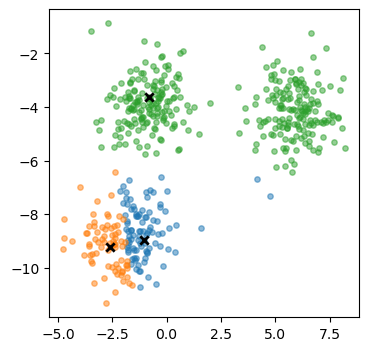

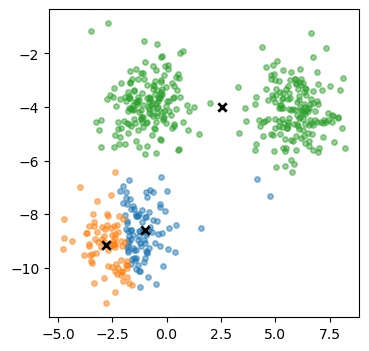

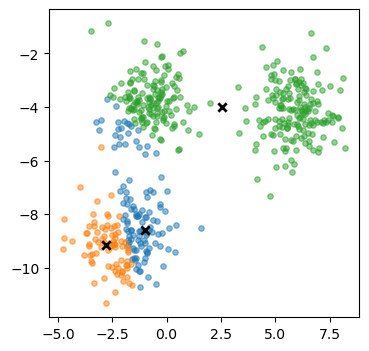

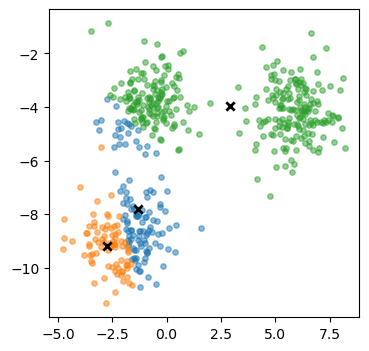

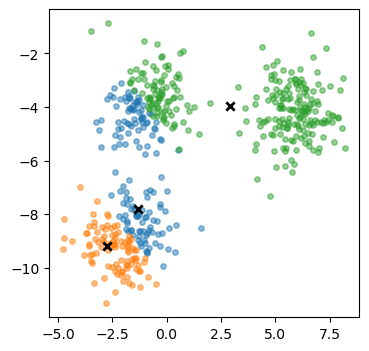

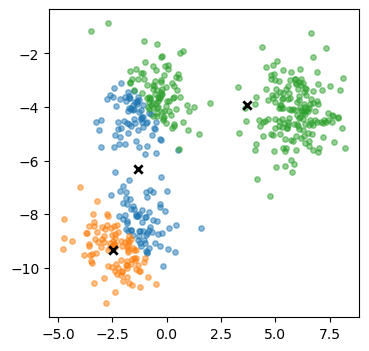

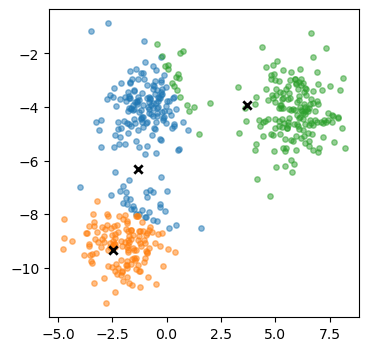

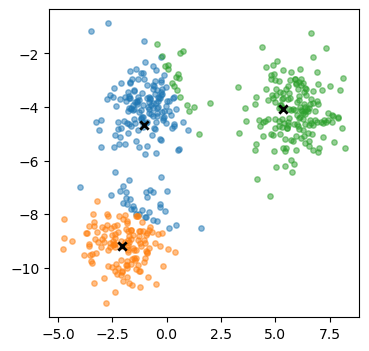

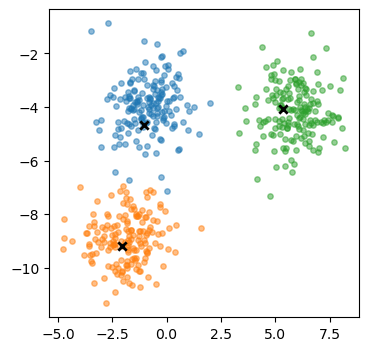

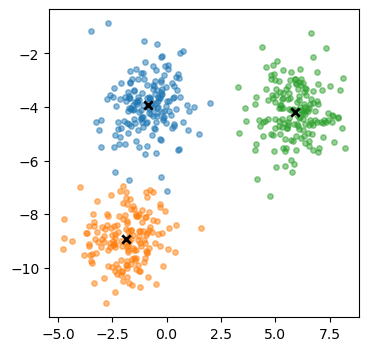

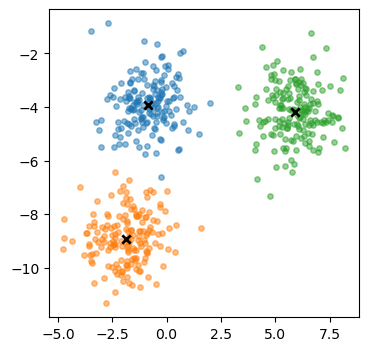

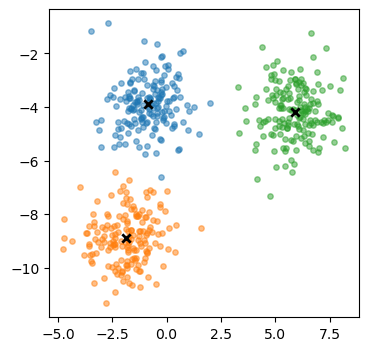

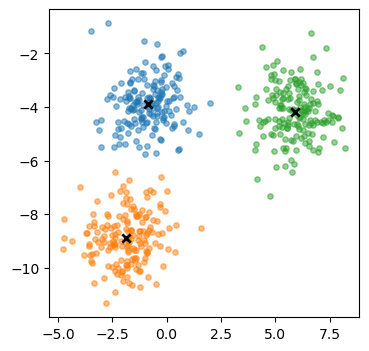

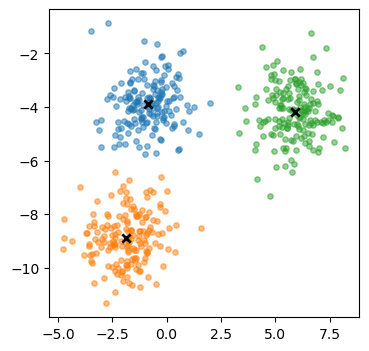

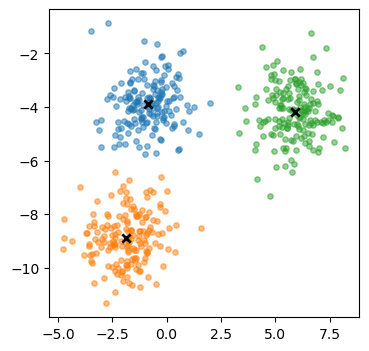

In [7]:
kmean = KMeans(n_clusters=3, init_centroid='random', plot_step=True)
prediction = kmean.predict(X)

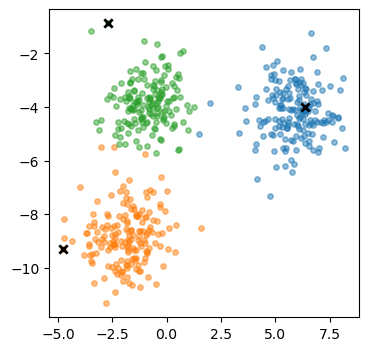

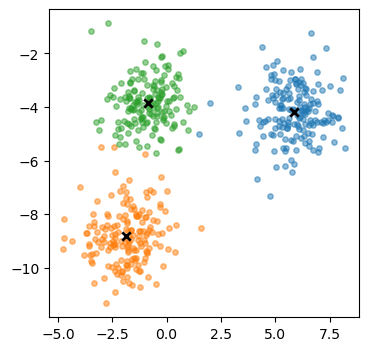

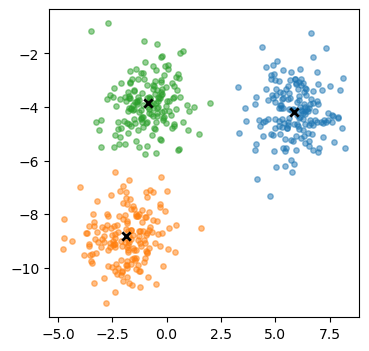

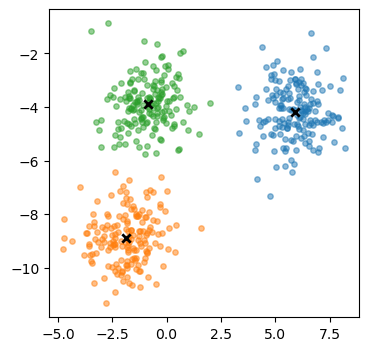

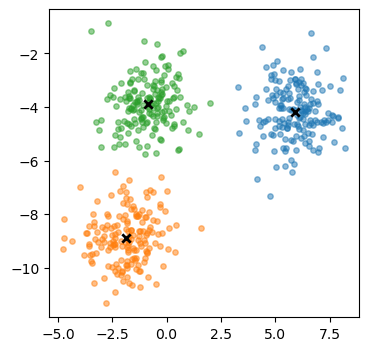

In [8]:
kmean = KMeans(n_clusters=3, init_centroid='farthest', plot_step=True)
prediction = kmean.predict(X)

### Hierarchical Clustering
Hierarchical clustering is a type of clustering algorithm that builds a hierarchy of clusters. There are two main approaches to hierarchical clustering: agglomerative and divisive.

**Agglomerative Hierarchical Clustering** (more common and widely used, aka bottom-up approach): 
1. Start:
    * Treat each data point as a single cluster
2. Merge:
    * Identify the two closest clusters and merge them into a single cluster
3. Update Distance Matrix:
    * Recalculate the distances between the new cluster and the remaining clusters
4. Repeat:
    * Repeat steps 2 and 3 until only one cluster remains, or until a stopping criterion is met

This results in a tree-based representation of the observations, called a dendrogram.

Each leaf of the dendrogram represents one of the n observations. As we move up the tree, some leaves begin to fuse into branches. These correspond to observations that are similar to each other. As we move higher up the tree, branches themselves fuse, either with leaves or other branches. The earlier
(lower in the tree) fusions occur, the more similar the groups of observations are to each other. On the other hand, observations that fuse later (near the top of the tree) can be quite diferent.

The height of this fusion, as measured on the vertical axis, indicates how different the two observations are. Thus, observations that fuse at the very bottom of the tree are quite similar to each other, whereas observations that fuse close to the top of the tree will tend to be quite diferent.

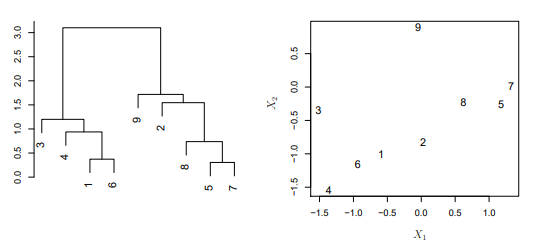
ISL - Figure 12.12
An illustration of how to properly interpret a dendrogram with nine observations in two-dimensional space. 
* Left: a dendrogram generated using Euclidean distance and complete linkage. Observations 5 and 7 are quite similar to each other, as are observations 1 and 6. However, observation 9 is no more similar to observation 2 than it is to observations 8, 5, and 7, even though observations 9 and 2 are close together in terms of horizontal distance. This is because observations 2, 8, 5, and 7 all fuse with observation 9 at the same height, approximately 1.8. 
* Right: the raw data used to generate the dendrogram can be used to confrm that indeed, observation 9 is no more similar to observation 2 than it is to observations 8, 5, and 7.

**Divisive hierarchical clustering** (aka top-down approach) works in the opposite way. It starts with all data points in a single cluster and recursively splits the cluster into smaller ones until each cluster contains only one data point.

**Distance Metric**:
The choice of distance metric is crucial in hierarchical clustering. Common distance metrics include Euclidean distance, Manhattan distance, and others.

**Linkage Criteria**:
The linkage criteria determine how the distance between clusters is calculated. Common linkage methods include:
* Complete Linkage: Based on the maximum distance between clusters
* Average Linkage: Based on the average distance between clusters
* Single Linkage: Based on the minimum distance between clusters
* Ward's Method: Minimizes the variance within each cluster

Hierarchical clustering is versatile and doesn't require specifying the number of clusters beforehand. However, it can be computationally expensive, especially for large datasets. The choice between agglomerative and divisive methods often depends on the specific problem and data characteristics.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_blobs
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix

In [2]:
plt.rcParams['figure.figsize'] = (4, 4)

### Distance Matrix

In [3]:
data = np.array([[5, 7], [7, 3], [8, 1]])

In [4]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [5]:
n = len(data)
dm = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):    # only iterate through the upper triangular matrix
        dm[i, j] = euclidean_distance(data[i], data[j])
        dm[j, i] = dm[i, j]
dm

array([[0.        , 4.47213595, 6.70820393],
       [4.47213595, 0.        , 2.23606798],
       [6.70820393, 2.23606798, 0.        ]])

In [6]:
# Scipy.spatial.distance_matrix
distance_matrix(data, data)

array([[0.        , 4.47213595, 6.70820393],
       [4.47213595, 0.        , 2.23606798],
       [6.70820393, 2.23606798, 0.        ]])

In [10]:
def euclidean_distances_matrix(X, Y):
    distances = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            distances[i, j] = euclidean_distance(X[i], Y[j])
    return distances

In [45]:
# Make data
X = np.array([[1, 2], [3, 4], [5, 6]])
Y = np.array([[7, 8], [9, 10]])

# Calculate Euclidean distances
euclidean_distances_matrix(X, Y)

array([[ 8.48528137, 11.3137085 ],
       [ 5.65685425,  8.48528137],
       [ 2.82842712,  5.65685425]])

In [9]:
# sklearn.metrics.pairwise.euclidean_distances
euclidean_distances(X, Y)

array([[ 8.48528137, 11.3137085 ],
       [ 5.65685425,  8.48528137],
       [ 2.82842712,  5.65685425]])

In [46]:
# Scipy.spatial.distance_matrix
distance_matrix(X, Y, p=2)   # param: p: Which Minkowski p-norm to use, default is 2

array([[ 8.48528137, 11.3137085 ],
       [ 5.65685425,  8.48528137],
       [ 2.82842712,  5.65685425]])

In [43]:
class HierarchicalClustering:
    def __init__(self, n_clusters=3, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.labels_ = np.zeros(self.n_samples, dtype=int)

        # Initialize clusters
        clusters = [[i] for i in range(self.n_samples)]

        while len(clusters) > self.n_clusters:
            # Find the closest clusters
            idx1, idx2 = self._find_closest_clusters(clusters)

            # Merge the clusters
            clusters[idx1].extend(clusters.pop(idx2))

        for i, cluster in enumerate(clusters):
            self.labels_[cluster] = i


    def _find_closest_clusters(self, clusters):
        min_distance = float('inf')
        closest_clusters = ()

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                distance = self._calculate_distance(clusters[i], clusters[j])
                if distance < min_distance:
                    min_distance = distance
                    closest_clusters = (i, j)

        return closest_clusters

    
    def _calculate_distance(self, cluster1, cluster2):
        if self.linkage == 'single':
            return np.min([np.linalg.norm(self.X[i] - self.X[j]) for i in cluster1 for j in cluster2])
        
        elif self.linkage == 'complete':
            return np.max([np.linalg.norm(self.X[i] - self.X[j]) for i in cluster1 for j in cluster2])
        
        elif self.linkage == 'average':
            return np.mean([np.linalg.norm(self.X[i] - self.X[j]) for i in cluster1 for j in cluster2])
        else:
            raise ValueError(f"Unsupported linkage method: {self.linkage}")

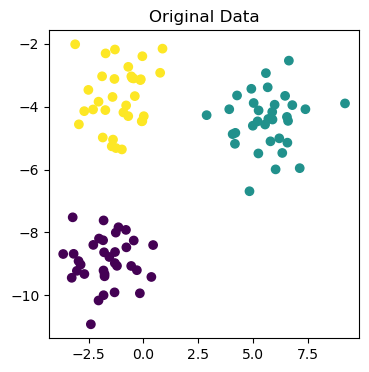

In [20]:
# Make data
X, y = make_blobs(centers=3, n_samples=100, n_features=2, cluster_std=1, 
                  shuffle=True, random_state=40)

# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Original Data');

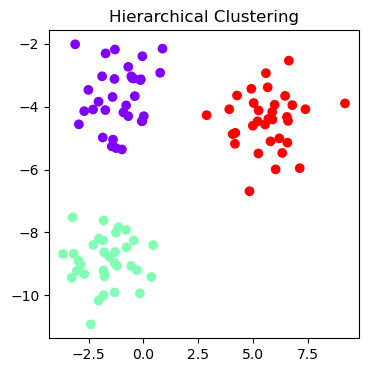

In [25]:
model = HierarchicalClustering(n_clusters=3, linkage='single')
model.fit(X)

# Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap='rainbow')
plt.title('Hierarchical Clustering');

### scipy.cluster.hierarchy.linkage
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

(n-1) x 4 matrix $Z$ is returned. 

At the ith iteration, clusters with indices $Z[i, 0]$ and $Z[i, 1]$ are combined. 

The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is given by $Z[i, 2]$ 

The fourth value $Z[i, 3]$ represents the number of original observations in the newly formed cluster.

In [4]:
# Make data
X, y = make_blobs(centers=3, n_samples=100, n_features=2, cluster_std=1, 
                  shuffle=True, random_state=40)

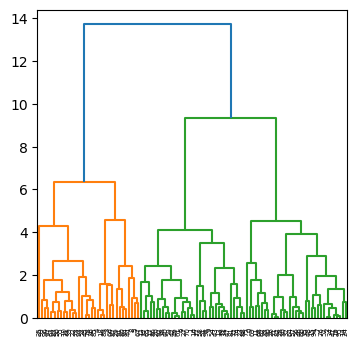

In [5]:
# scipy agglomerative cluster
Z = hierarchy.linkage(X, 'complete')
hierarchy.dendrogram(Z);

In [5]:
Z.shape

(99, 4)

In [6]:
# Make smaller data
X, y = make_blobs(centers=3, n_samples=5, n_features=2, cluster_std=1, 
                  shuffle=True, random_state=40)

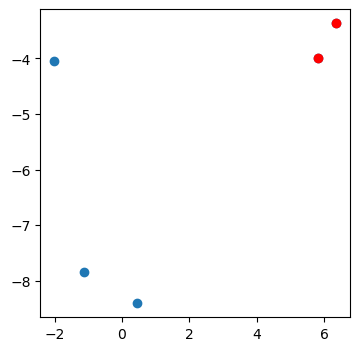

In [7]:
# The 2 red points are the first to linked
plt.scatter(X[:, 0], X[:, 1])
plt.plot(X[1, 0], X[1, 1], c='r', marker='o');
plt.plot(X[4, 0], X[4, 1], c='r', marker='o');

In [8]:
X

array([[ 0.4462309 , -8.40386914],
       [ 5.82477065, -3.99594289],
       [-1.13599245, -7.83714475],
       [-2.00999528, -4.05544692],
       [ 6.3589792 , -3.36865207]])

### Interpret Z (linkage matrix):

The first 2 columns identify the objects (indices) that have been linked. The third column contains the distance between these objects, and the fourth column represents the number of objects in the cluster.

In [9]:
Z = hierarchy.linkage(X, 'single')
Z

array([[1.        , 4.        , 0.82393722, 2.        ],
       [0.        , 2.        , 1.6806568 , 2.        ],
       [3.        , 6.        , 3.88138112, 3.        ],
       [5.        , 7.        , 6.95402787, 5.        ]])

In [10]:
# Interpreting first row of Z:
# The first two points that are linked are X[1] and X[4]
euclidean_distance(X[1], X[4])    # this is the content of Z[0, 2]

0.8239372244968342

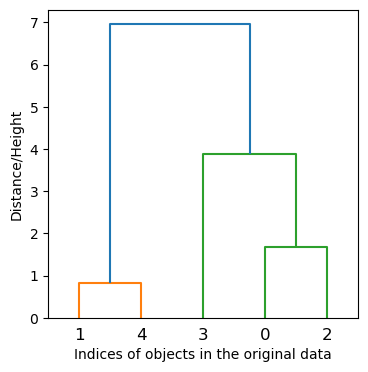

In [12]:
hierarchy.dendrogram(Z)
plt.xlabel('Indices of objects in the original data')
plt.ylabel('Distance/Height');

### Agglomerative Clustering Class
The fit function will return Z: ndarray

     The hierarchical clustering encoded as a linkage matrix
as in scipy.cluster.hierarchy.linkage

In [69]:
class Agglomerative_Clustering:
    def __init__(self, verbose=False, linkage_type='complete'):
        self.verbose = verbose
        self.linkage_type = linkage_type
        
    def _argmin(self, Distance):
        """
        Param: Distance: 2D array of size mxm
        Return: indices of the min value in Distance
        """
        x_idx, y_idx = (0, 0)
        min_val = float('inf')
        m = Distance.shape[0]
        
        for i in range(m):
            for j in range(i + 1, m):
                if Distance[i, j] < min_val:
                    min_val = Distance[i, j]
                    x_idx, y_idx = (i, j)
                    
        return x_idx, y_idx
    
    
    def _cluster_distance(self, cluster_members):
        """
        Use scipy's euclidean_distances to compute distances between clusters
        """
        n_clusters = len(cluster_members)
        keys = list(cluster_members.keys())
        Distance = np.zeros((n_clusters, n_clusters))
        
        for i in range(n_clusters):
            ith_elems = cluster_members[keys[i]]
            for j in range(i + 1, n_clusters):
                jth_elems = cluster_members[keys[j]]
                
                distances = euclidean_distances(X[ith_elems], X[jth_elems])
                
                if self.linkage_type == 'complete':
                    dij = np.max(distances)
                elif self.linkage_type == 'single':
                    dij = np.min(distances)
                elif self.linkage_type == 'average':
                    dij = np.mean(distances)
                    
                Distance[i, j] = dij
                Distance[j, i] = dij

        return Distance     
    
    
    def fit(self, X):
        """
        Return: Z : 2D array of shape (n_samples - 1) by 4
        Z is a Linkage matrix that stores the merge information at each iteration.
        """
        self.n_samples = X.shape[0]
        self.Z = np.zeros((self.n_samples - 1, 4))
        
        # Treat each sample as a single cluster, store only sample indices
        cluster_members = dict([(i, [i]) for i in range(self.n_samples)])
        
        for i in range(self.n_samples - 1):
            if self.verbose:
                print(f'\n-------\nDebug Line at, i={i}\n--------')
                
            keys = list(cluster_members.keys())
            
            # caculate the distance between existing clusters
            Distance = self._cluster_distance(cluster_members)
            
            # Find cluster indices with min distance, they will be merged
            x_idx, y_idx = self._argmin(Distance)
            
            if self.verbose:
                print(f'Z:\n{self.Z} \nCluster Members: {cluster_members} \nDistance:\n{pd.DataFrame(Distance)}')            
            
            x = keys[x_idx]
            y = keys[y_idx]
            
            self.Z[i,0] = x
            self.Z[i,1] = y
            self.Z[i,2] = Distance[x_idx, y_idx]
            self.Z[i,3] = len(cluster_members[x]) + len(cluster_members[y])
            
            # new cluster of merged objects is created
            cluster_members[i + self.n_samples] = cluster_members[x] + cluster_members[y]
            
            # remove merged clusters from the clusters pool
            del cluster_members[x]
            del cluster_members[y]
            
        return self.Z

    
    def predict(self, n_clusters):
        """      
        Return: a list: Cluster labels for each sample.
        """
        labels = np.zeros(self.n_samples)
        cluster_members = dict([(i, [i]) for i in range(self.n_samples)])
        
        for i in range(self.n_samples - n_clusters):
            x, y = (self.Z[i, 0], self.Z[i, 1])
            cluster_members[self.n_samples + i] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]
            
        keys = list(cluster_members.keys())
        
        for i in range(len(keys)):
            sample_indices = cluster_members[keys[i]]
            labels[sample_indices] = i
            
        return labels

In [70]:
# Testing 
X, y = make_blobs(centers=3, n_samples=5, n_features=2, cluster_std=1, 
                  shuffle=True, random_state=40)

In [71]:
X

array([[ 0.4462309 , -8.40386914],
       [ 5.82477065, -3.99594289],
       [-1.13599245, -7.83714475],
       [-2.00999528, -4.05544692],
       [ 6.3589792 , -3.36865207]])

In [72]:
hc = Agglomerative_Clustering(verbose=True, linkage_type='complete')
Z = hc.fit(X)
myLabel = hc.predict(n_clusters=3)


-------
Debug Line at, i=0
--------
Z:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
Cluster Members: {0: [0], 1: [1], 2: [2], 3: [3], 4: [4]} 
Distance:
          0         1         2         3         4
0  0.000000  6.954028  1.680657  4.994179  7.766209
1  6.954028  0.000000  7.950286  7.834992  0.823937
2  1.680657  7.950286  0.000000  3.881381  8.725940
3  4.994179  7.834992  3.881381  0.000000  8.397108
4  7.766209  0.823937  8.725940  8.397108  0.000000

-------
Debug Line at, i=1
--------
Z:
[[1.         4.         0.82393722 2.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]] 
Cluster Members: {0: [0], 2: [2], 3: [3], 5: [1, 4]} 
Distance:
          0         1         2         3
0  0.000000  1.680657  4.994179  7.766209
1  1.680657  0.000000  3.881381  8.725940
2  4.994179  3.881381  0.000000  8.397108
3  7.766209  8.725940  8.397108  0.000000

-------
Debu

In [73]:
# Sklearn AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3,linkage='complete').fit(X)
skLabel = clustering.labels_

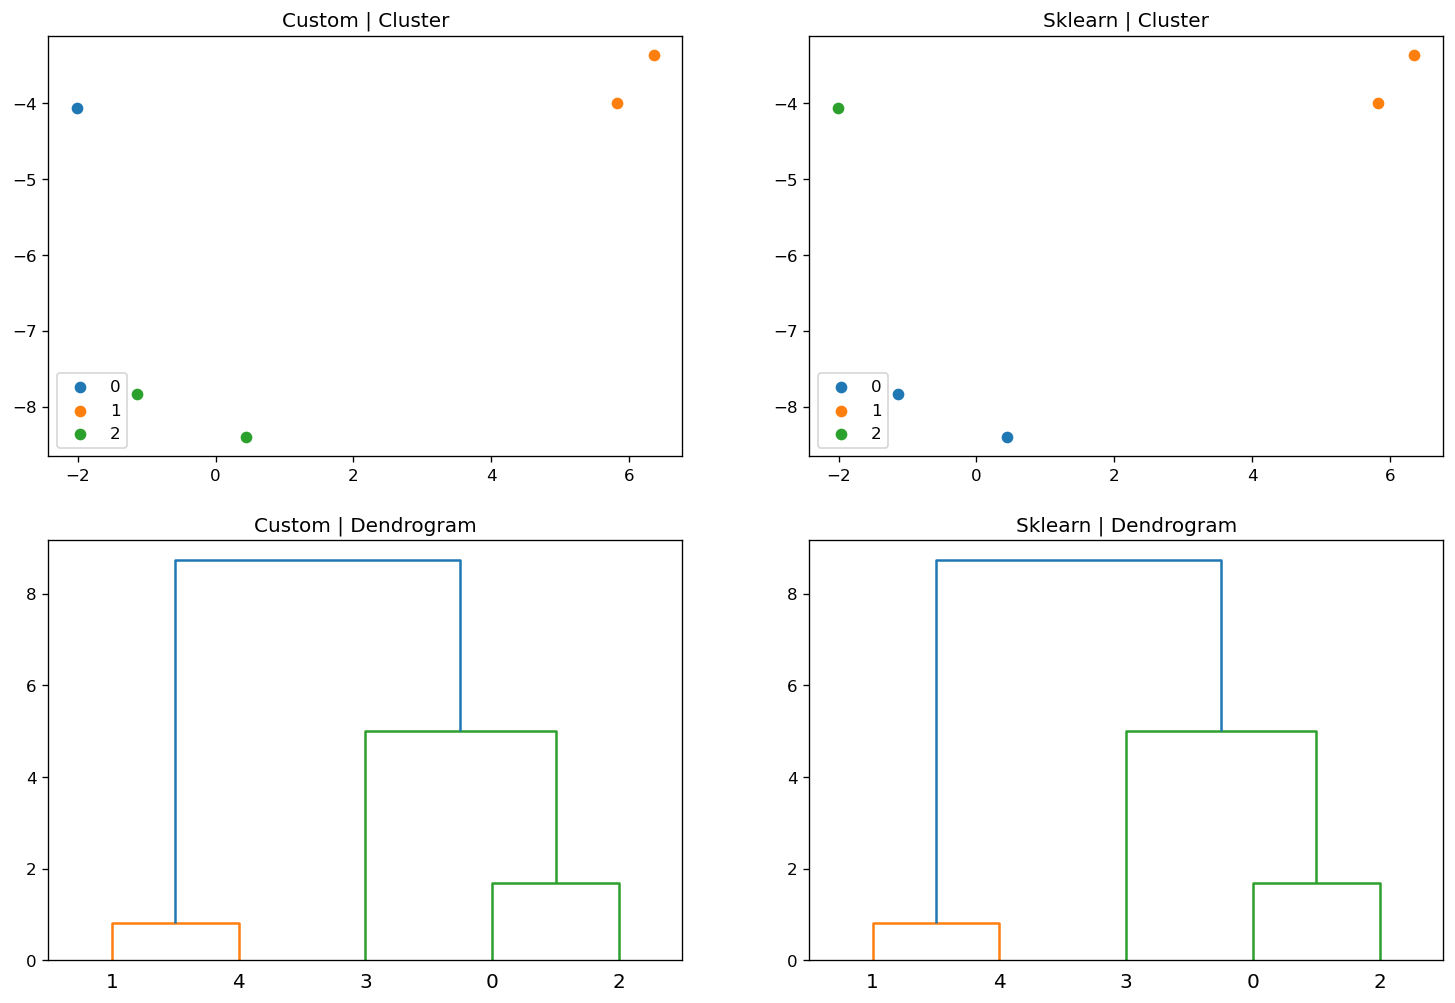

In [74]:
fig, ax = plt.subplots(2, 2, facecolor='white', figsize=(15, 5*2), dpi=120)

n_clusters = 3
for i in range(n_clusters):
    myIndices = myLabel==i
    skIndices = skLabel==i
    ax[0,0].scatter(x=X[myIndices,0], y=X[myIndices,1], label=i)
    ax[0,1].scatter(x=X[skIndices,0], y=X[skIndices,1], label=i)
    
ax[0,0].set_title('Custom | Cluster')
ax[0,1].set_title('Sklearn | Cluster')
ax[0,0].legend()
ax[0,1].legend()

# Dendrogram
z = hierarchy.linkage(X, 'complete')    # scipy agglomerative cluster
hierarchy.dendrogram(Z, ax=ax[1,0])     # plotting Z from my code
hierarchy.dendrogram(z, ax=ax[1,1])     # plotting Scipy's Z

ax[1,0].set_title('Custom | Dendrogram')
ax[1,1].set_title('Sklearn | Dendrogram')
plt.show()

In [24]:
import time

In [22]:
# Testing with more samples
X, y = make_blobs(centers=3, n_samples=100, n_features=2, cluster_std=1, 
                  shuffle=True, random_state=40)

In [25]:
start_time = time.time()
hc = Agglomerative_Clustering(verbose=False, linkage_type='complete')
Z = hc.fit(X)
myLabel = hc.predict(n_clusters=3)
elapsed_time = (time.time() - start_time)
print('Agglomerative_Clustering evaluation in {:.2f} seconds'.format(elapsed_time))

Agglomerative_Clustering evaluation in 26.10 seconds


In [26]:
# Sklearn AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3,linkage='complete').fit(X)
skLabel = clustering.labels_

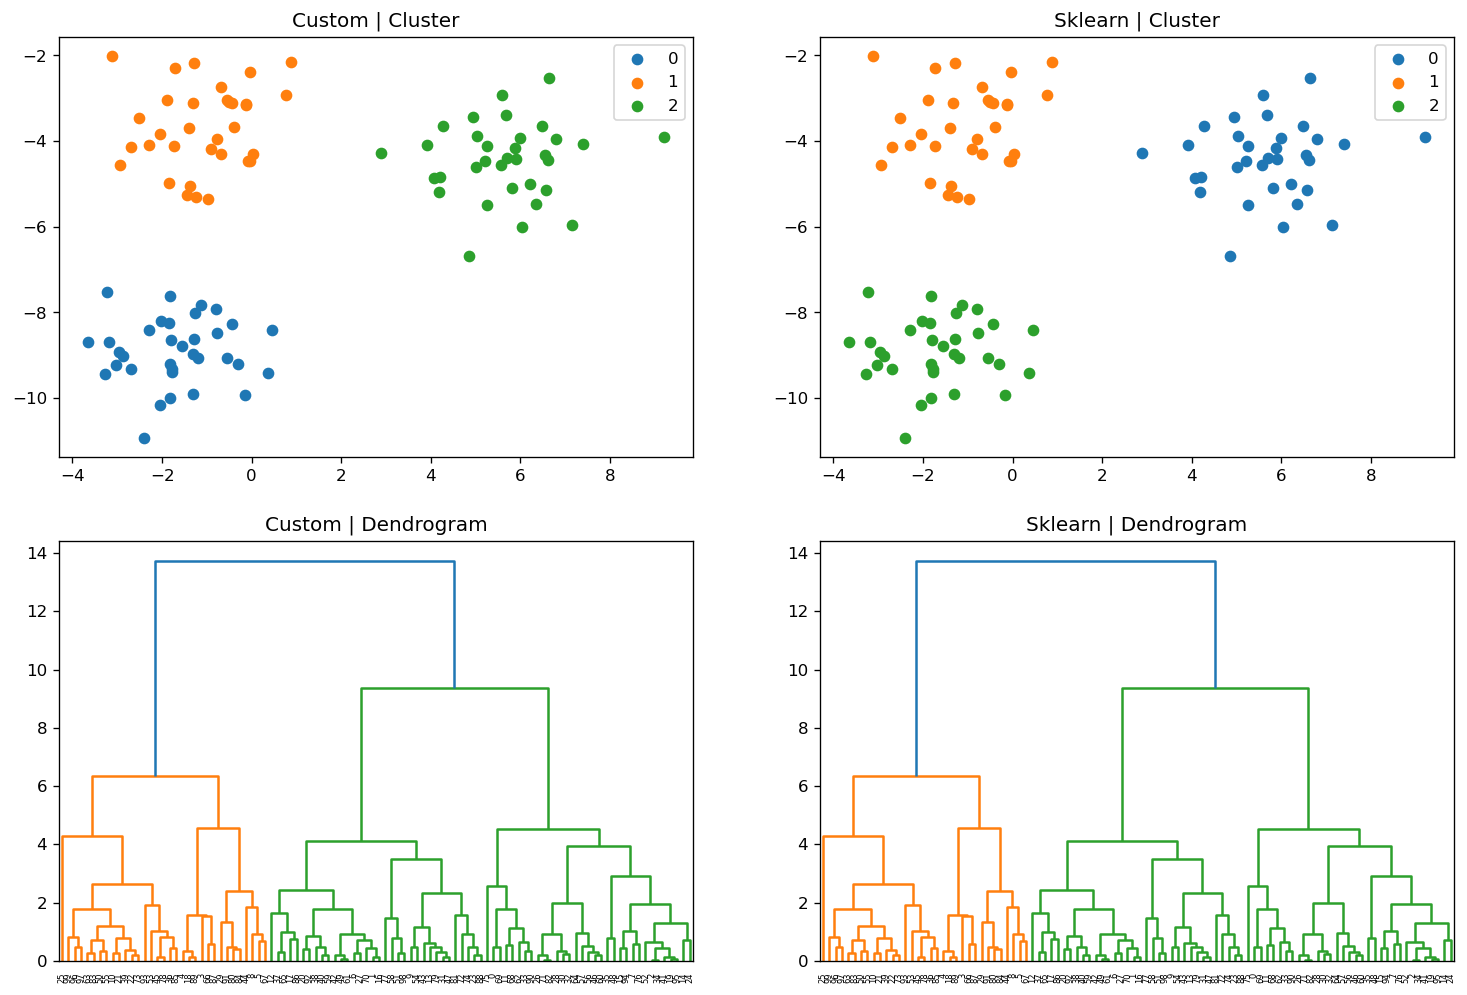

In [27]:
fig, ax = plt.subplots(2, 2, facecolor='white', figsize=(15, 5*2), dpi=120)

n_clusters = 3
for i in range(n_clusters):
    myIndices = myLabel==i
    skIndices = skLabel==i
    ax[0,0].scatter(x=X[myIndices,0], y=X[myIndices,1], label=i)
    ax[0,1].scatter(x=X[skIndices,0], y=X[skIndices,1], label=i)
    
ax[0,0].set_title('Custom | Cluster')
ax[0,1].set_title('Sklearn | Cluster')
ax[0,0].legend()
ax[0,1].legend()

# Dendrogram
z = hierarchy.linkage(X, 'complete')    # scipy agglomerative cluster
hierarchy.dendrogram(Z, ax=ax[1,0])     # plotting Z from my code
hierarchy.dendrogram(z, ax=ax[1,1])     # plotting Scipy's Z

ax[1,0].set_title('Custom | Dendrogram')
ax[1,1].set_title('Sklearn | Dendrogram')
plt.show()

### Choice of Dissimilarity Measure - ISL

Sometimes other dissimilarity measures might be preferred. For example, correlation-based distance considers two observations to be similar if their features are highly correlated, even though the
observed values may be far apart in terms of Euclidean distance.

Consider an online retailer interested in clustering shoppers based on their past shopping histories. The goal is to identify subgroups of similar shoppers. Suppose the data takes the form of a matrix where the rows are the shoppers and the columns are the items available for purchase; the elements of the data matrix indicate the number of times a given shopper has purchased a given item (i.e. a 0 if the shopper has never purchased this item, a 1 if the shopper has purchased it once, etc.) 

What type of dissimilarity measure should be used to cluster the shoppers? If Euclidean distance is used, then shoppers who have bought very few items overall (i.e. infrequent users of the online shopping site) will be clustered together. This may not be desirable. On the other hand, if correlation-based distance is used, then shoppers with similar preferences (e.g. shoppers who have bought items A and B but never items C or D) will be clustered together, even if some shoppers with
these preferences are higher-volume shoppers than others. Therefore, for this application, correlation-based distance may be a better choice.

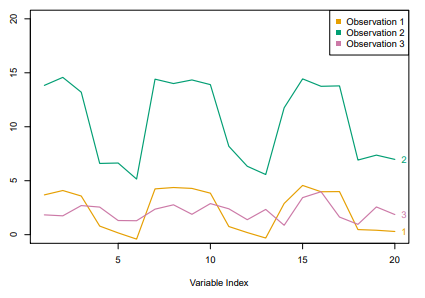
ISL - FIGURE 12.15. Three observations with measurements on 20 variables are shown. Observations 1 and 3 have similar values for each variable and so there is a small Euclidean distance between them. But they are very weakly correlated, so they have a large correlation-based distance. On the other hand, observations 1 and 2 have quite diferent values for each variable, and so there is a large Euclidean distance between them. But they are highly correlated, so there is a small correlation-based distance between them.

Pearson Correlation Coefficient:
$$r = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}$$

In [1]:
import numpy as np

In [2]:
def correlation_distance(X, Y):
    # Calculate the mean
    mean_x = np.mean(X)
    mean_y = np.mean(Y)

    # Calculate the numerator and denominators for the correlation coefficient
    numerator = np.sum((X - mean_x) * (Y - mean_y))
    denominator_x = np.sqrt(np.sum((X - mean_x)**2))
    denominator_y = np.sqrt(np.sum((Y - mean_y)**2))

    # Calculate the correlation coefficient
    correlation_coefficient = numerator / (denominator_x * denominator_y)

    # Calculate the correlation-based distance
    distance = 1 - correlation_coefficient

    return distance

In [16]:
# Testing
x = np.array([1, 2, 3, 4, 5])
y = np.array([5, 4, 1, 2, 1])
z = np.array([10, 20, 30, 40, 50])

distance = correlation_distance(x, y)
print('Correlation-based distance (x, y):', np.round(distance, 2))
distance = correlation_distance(x, z)
print('Correlation-based distance (x, z):', distance)

Correlation-based distance (x, y): 1.87
Correlation-based distance (x, z): 0.0
